___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___
<center>*Copyright Pierian Data 2017*</center>
<center>*For more information, visit us at www.pieriandata.com*</center>

#### Warning! This is a complicated topic! Remember that this is an optional notebook to go through and that to fully understand it you should read the supplemental links and watch the full explanatory walkthrough video. This notebook and the video lectures are not meant to be a full comprehensive overview of ARIMA, but instead a walkthrough of what you can use it for, so you can later understand why it may or may not be a good choice for Financial Stock Data.
____


# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model
* Use the model to make predictions

Let's go through these steps!

## Step 1: Get the Data (and format it)

We will be using some data about monthly milk production, full details on it can be found [here](https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line).

Its saved as a csv for you already, let's load it up:

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [4]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [5]:
df.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


** Clean Up**

Let's clean this up just a little!

In [6]:
df.columns = ['Month','Milk in pounds per cow']
df.head()

,Month,Milk in pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [7]:
# Weird last value at bottom causing issues
df.drop(168,axis=0,inplace=True)

In [13]:
df['Month'] = pd.to_datetime(df['Month'])

In [14]:
df.head()

,Month,Milk in pounds per cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


In [15]:
df.set_index('Month',inplace=True)

In [16]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in pounds per cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


## Step 2: Visualize the Data

Let's visualize this data with a few methods.

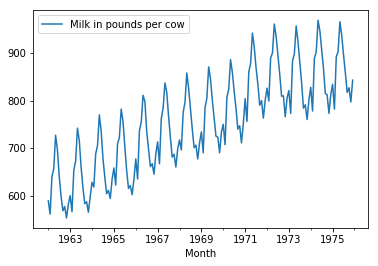

In [17]:
df.plot()

In [18]:
timeseries = df['Milk in pounds per cow']


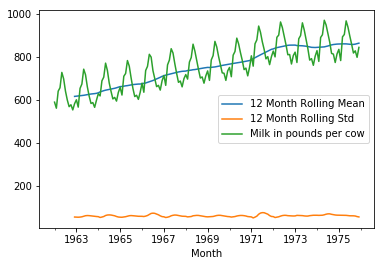

In [19]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

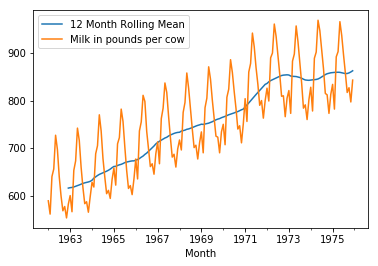

In [20]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

## Decomposition

ETS decomposition allows us to see the individual parts!

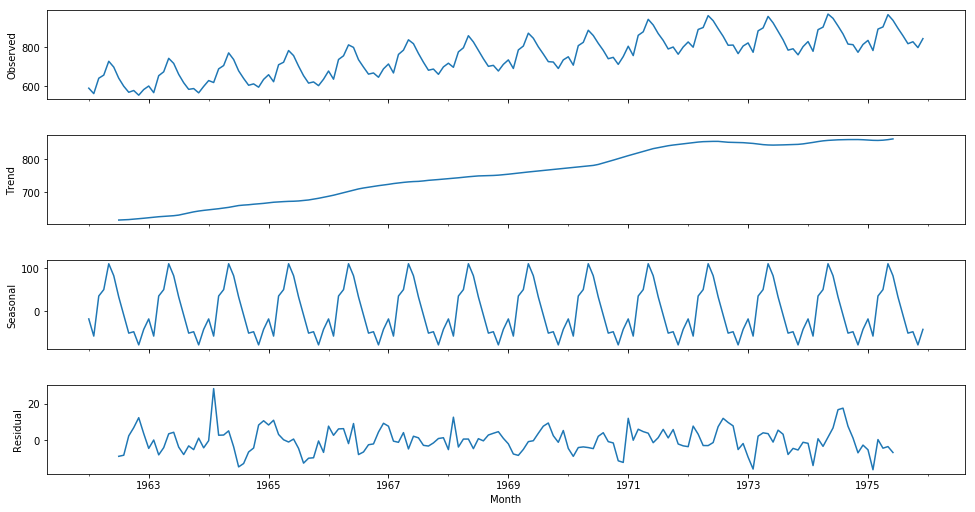

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk in pounds per cow'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [22]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
result = adfuller(df['Milk in pounds per cow'])
result

(-1.3038115874221314,
 0.62742670860303074,
 13,
 154,
 {'1%': -3.4735425281962091,
  '10%': -2.5768780536346769,
  '5%': -2.880497674144038},
 1115.1730447395112)

In [28]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.30381158742
p-value : 0.627426708603
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [29]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

___________

## Important Note!

** We have now realized that our data is seasonal (it is also pretty obvious from the plot itself). This means we need to use Seasonal ARIMA on our model. If our data was not seasonal, it means we could use just ARIMA on it. We will take this into account when differencing our data! Typically financial stock data won't be seasonal, but that is kind of the point of this section, to show you common methods, that won't work well on stock finance data!**

_____

## Differencing

The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

** First Difference **

In [30]:
df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

In [31]:
adf_check(df['Milk First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.05499555865
p-value : 0.0300680040018
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


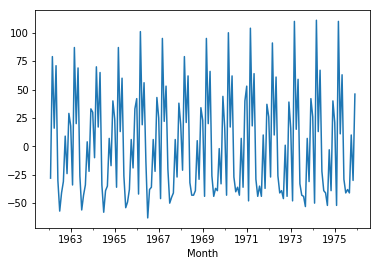

In [32]:
df['Milk First Difference'].plot()

** Second Difference **

In [33]:
# Sometimes it would be necessary to do a second difference 
# This is just for show, we didn't need to do a second difference in our case
df['Milk Second Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(1)

In [34]:
adf_check(df['Milk Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -14.3278736456
p-value : 1.11269893321e-26
#Lags Used : 11
Number of Observations Used : 154
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


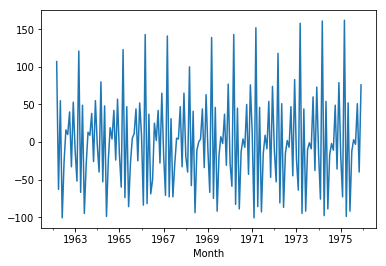

In [35]:
df['Milk Second Difference'].plot()

** Seasonal Difference **

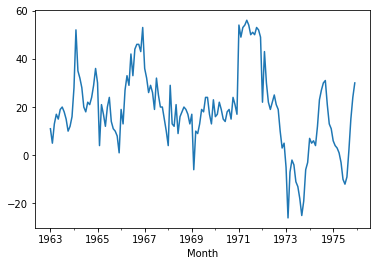

In [36]:
df['Seasonal Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)
df['Seasonal Difference'].plot()

In [37]:
# Seasonal Difference by itself was not enough!
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.33541931436
p-value : 0.160798805277
#Lags Used : 12
Number of Observations Used : 143
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


** Seasonal First Difference **

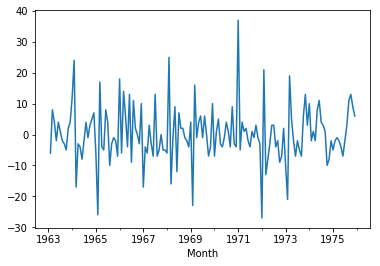

In [38]:
# You can also do seasonal first difference
df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [39]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.03800227492
p-value : 1.86542343188e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


# Autocorrelation and Partial Autocorrelation Plots

An autocorrelation plot (also known as a [Correlogram](https://en.wikipedia.org/wiki/Correlogram) ) shows the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag.

So imagine taking your time series of length T, copying it, and deleting the first observation of copy #1 and the last observation of copy #2. Now you have two series of length T−1 for which you calculate a correlation coefficient. This is the value of of the vertical axis at x=1x=1 in your plots. It represents the correlation of the series lagged by one time unit. You go on and do this for all possible time lags x and this defines the plot.

You will run these plots on your differenced/stationary data. There is a lot of great information for identifying and interpreting ACF and PACF [here](http://people.duke.edu/~rnau/arimrule.htm) and [here](https://people.duke.edu/~rnau/411arim3.htm).

### Autocorrelation Interpretation

The actual interpretation and how it relates to ARIMA models can get a bit complicated, but there are some basic common methods we can use for the ARIMA model. Our main priority here is to try to figure out whether we will use the AR or MA components for the ARIMA model (or both!) as well as how many lags we should use. In general you would use either AR or MA, using both is less common.

* If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag

* If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms.

_____
### <font color='red'> Important Note! </font> 

Here we will be showing running the ACF and PACF on multiple differenced data sets that have been made stationary in different ways, typically you would just choose a single stationary data set and continue all the way through with that.

The reason we use two here is to show you the two typical types of behaviour you would see when using ACF.
_____

In [40]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

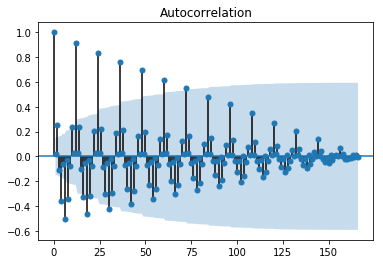

In [41]:
# Duplicate plots
# Check out: https://stackoverflow.com/questions/21788593/statsmodels-duplicate-charts
# https://github.com/statsmodels/statsmodels/issues/1265
fig_first = plot_acf(df["Milk First Difference"].dropna())

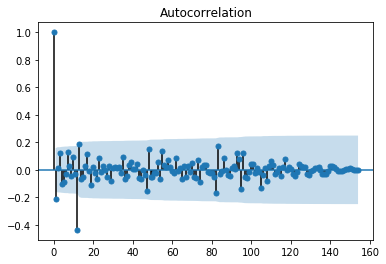

In [42]:
fig_seasonal_first = plot_acf(df["Seasonal First Difference"].dropna())

Pandas also has this functionality built in, but only for ACF, not PACF. So I recommend using statsmodels, as ACF and PACF is more core to its functionality than it is to pandas' functionality.

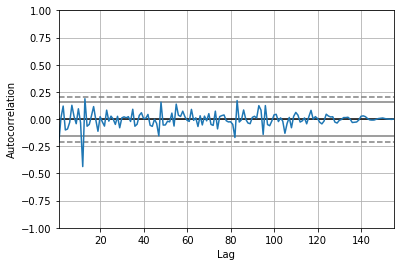

In [43]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Seasonal First Difference'].dropna())

## Partial Autocorrelation

In general, a partial correlation is a conditional correlation.

It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.

For instance, consider a regression context in which y = response variable and x1, x2, and x3 are predictor variables.  The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

Formally, this is relationship is defined as:

## $\frac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

Check out this [link](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm) for full details on this.

We can then plot this relationship:

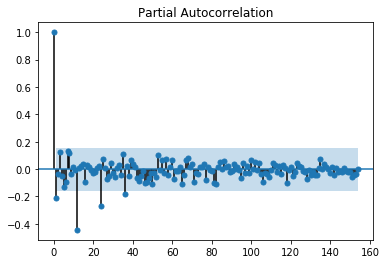

In [44]:
result = plot_pacf(df["Seasonal First Difference"].dropna())

### Interpretation

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

_____
### Final ACF and PACF Plots

We've run quite a few plots, so let's just quickly get our "final" ACF and PACF plots. These are the ones we will be referencing in the rest of the notebook below.
_____

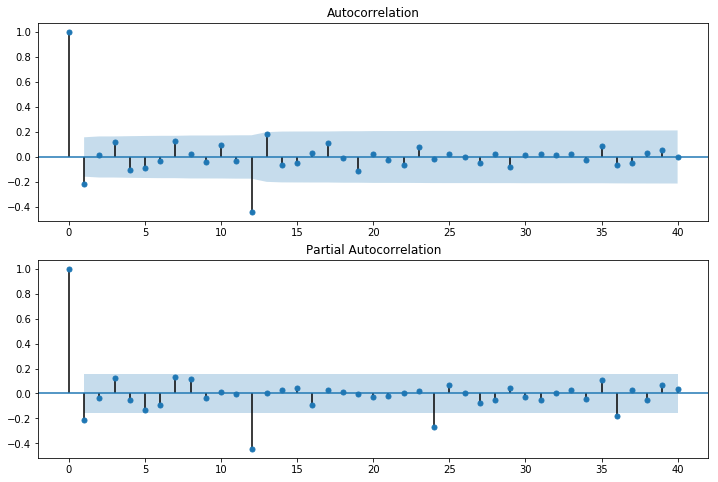

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

## Using the Seasonal ARIMA model

Finally we can use our ARIMA model now that we have an understanding of our data!

In [49]:
# For non-seasonal data
from statsmodels.tsa.arima_model import SARIMAX


ImportError: cannot import name 'SARIMAX'

In [47]:
# I recommend you glance over this!

# 
help(SARIMAX)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

### p,d,q parameters

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

In [56]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'],order=(1,1,1), seasonal_order=(1,1,1,6))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:            Milk in pounds per cow   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -654.674
Date:                           Sun, 04 Feb 2018   AIC                           1319.347
Time:                                   23:56:23   BIC                           1334.967
Sample:                               01-01-1962   HQIC                          1325.686
                                    - 12-01-1975                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5165      0.036    -14.419      0.000      -0.587      -0.446
ma.L1          0.9822      0.010    102.669

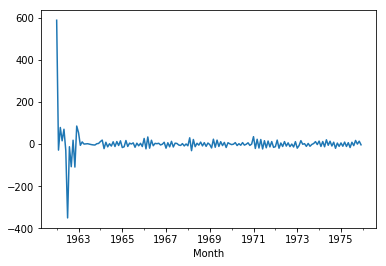

In [57]:
results.resid.plot()

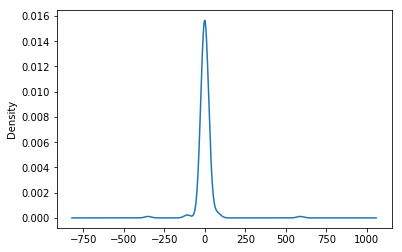

In [58]:
results.resid.plot(kind='kde')

## Prediction of Future Values

Firts we can get an idea of how well our model performs by just predicting for values that we actually already know:

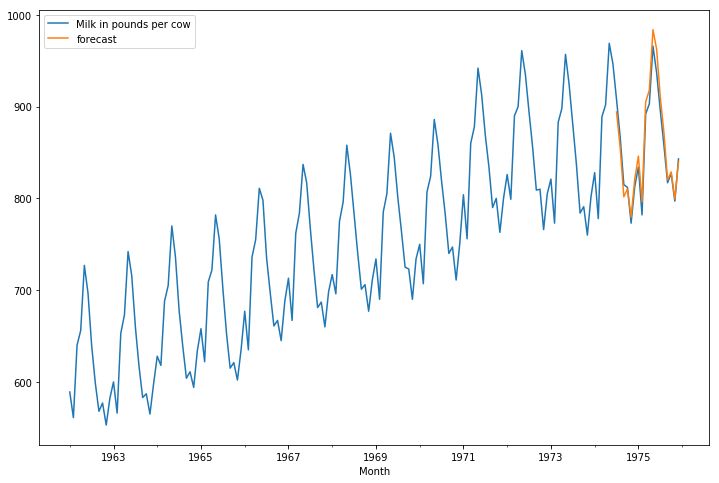

In [59]:
df['forecast'] = results.predict(start = 150, end= 168, dynamic= True)  
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))

### Forecasting
This requires more time periods, so let's create them with pandas onto our original dataframe!

In [60]:
df.tail()

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
Month,,,,,,
1975-08-01,858.0,-38.0,3.0,-9.0,3.0,872.009458
1975-09-01,817.0,-41.0,-3.0,2.0,11.0,820.208963
1975-10-01,827.0,10.0,51.0,15.0,13.0,828.817703
1975-11-01,797.0,-30.0,-40.0,24.0,9.0,799.320951
1975-12-01,843.0,46.0,76.0,30.0,6.0,839.960789


In [45]:
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html
# Alternatives 
# pd.date_range(df.index[-1],periods=12,freq='M')

In [61]:
from pandas.tseries.offsets import DateOffset

In [65]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,24) ]

In [48]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [67]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_dates_df

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-11-01,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
future_df = pd.concat([df,future_dates_df])

In [51]:
future_df.head()

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1962-01-01,589.0,NaN,NaN,NaN,NaN,NaN
1962-02-01,561.0,-28.0,NaN,NaN,NaN,NaN
1962-03-01,640.0,79.0,107.0,NaN,NaN,NaN
1962-04-01,656.0,16.0,-63.0,NaN,NaN,NaN
1962-05-01,727.0,71.0,55.0,NaN,NaN,NaN


In [69]:
future_df.tail()

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN,NaN


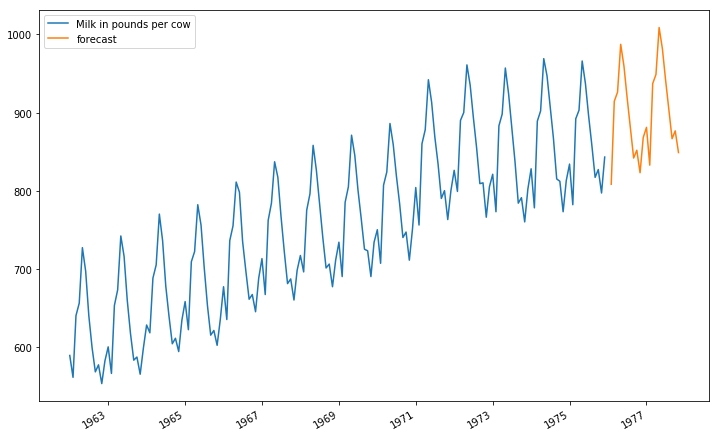

In [73]:
future_df['forecast'] = results.predict(start = 168, end = 200, dynamic= True)  
future_df[['Milk in pounds per cow', 'forecast']].plot(figsize=(12, 8)) 

Not bad! Pretty cool in fact! I hope this helped you see the potential for ARIMA models, unfortunately a lot of financial data won't follow this sort of behaviour, in fact it will often follow something indicating brownian motion, what is that you ask? Well head on over to the next video section and we'll find out!

# Great Job!